<a href="https://colab.research.google.com/github/prasadshreyas/Covid-Fake-News-Detection/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ablation Study of Transfomers on Fake News Dataset


*BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers


**To-do list:**
- [X] Use the base `bert-base` to build a high performing model
- [X] Use traditional preprocessing steps to clean the text and compare the results
- [X] Build methods to run experiments
- [ ] Build methods to visualize architectures, ROC and inner representations of the fake vs not fake
- [ ] Experiment w/ Vectorizers
- [ ] Experiment w/ other Architectures: `bert-large`, `distill-bert`, and `roberta`


# 1. Imports

In [1]:
!pip install transformers==3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 754 kB 4.9 MB/s 
     |████████████████████████████████| 880 kB 46.6 MB/s 
     |████████████████████████████████| 3.0 MB 18.2 MB/s 
     |████████████████████████████████| 1.3 MB 56.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=a162519a533ba1cdd332c9f9283604b4380be79323497650ee9f7b851d816234
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

Split train dataset into train, validation and test sets

In [16]:
# Load the train data
train_url = "https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Train.csv"
train_df = pd.read_csv(train_url)

# Load the validation data
val_url = "https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Val.csv"
val_df = pd.read_csv(val_url)

# Load the test data
test_url = "https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/english_test_with_labels.csv"
test_df = pd.read_csv(test_url)

Import BERT Model and BERT Tokenizer


In [11]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]


**Some Notes**


* Since we are using a pretrained model, it’s important to use the associated pretrained tokenizer. 
* This ensures the text is split the same way as the pretraining corpus, and uses the same corresponding vocab during pretraining.
* Hence, we are using the `BertTokenizer`.



# 2. Task: Build a high-performing BERT model on the train dataset
Binary Encoding

In [17]:
def map_to_binary(df):
    """ Maps the labels to binary
    Input:
        df: pandas dataframe
    Output:
        df: pandas dataframe
     """
    df['label'] = df['label'].map({'fake': 1, 'real': 0})
    return df

train_df = map_to_binary(train_df)
val_df = map_to_binary(val_df)
test_df = map_to_binary(test_df)

Upsampling any unbalanced datasets

In [18]:
def balance_dataset(df):
    """ Upsamples the Fake News Dataset
    Input:
        df: pandas dataframe
    Output:
        df: pandas dataframe
     """
    
    df_real = df[df['label'] == 0]
    df_fake = df[df['label'] == 1]
    df_real_upsampled = resample(df_real, replace=True, n_samples=len(df_fake), random_state=123)
    df_upsampled = pd.concat([df_real_upsampled, df_fake])
    return df_upsampled

train_df = balance_dataset(train_df)

Remove outliers

In [19]:
train_df = train_df[train_df['tweet'].apply(len) < 200]
train_df = train_df[train_df['tweet'].apply(len) > 1]

Plot the Boxplot of the length of the tokens

In [23]:
import matplotlib.pyplot as plt
def display_boxplot(series):
    """ Plots the boxplot of the length of the tweets
    Input:
        df: pandas series of strings
    Output:
        None
     """
    
    count = []
    for sentence in series:
        count.append(len(sentence.split()))
    
    plt.xlabel('Length of Tweets')
    plt.ylabel('Frequency')
    plt.title('Histogram of Length of Tweets')
    plt.boxplot(count)
    plt.show()

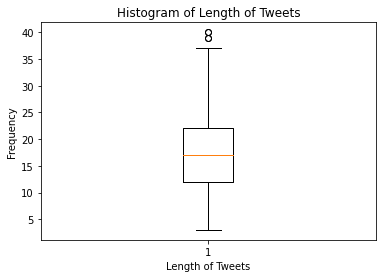

In [24]:
display_boxplot(train_df['tweet'])

Raw texts and labels

In [20]:
train_text, train_labels = train_df['tweet'], train_df['label']
test_text, test_labels = test_df['tweet'], test_df['label']
val_text, val_labels = val_df['tweet'], val_df['label']

Tokenization of Texts

In [15]:
max_seq_len = 50

In [16]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [17]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [19]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

- [ ] Check only if the bert is set to false
- Training the entire model takes days.

# Define Model Architecture

In [20]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [21]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [22]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [23]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes = np.unique(train_labels), y = train_labels)

print(class_wts)

[1. 1.]


In [42]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

# Fine-Tune BERT

In [25]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [26]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [27]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    210.
  Batch   100  of    210.
  Batch   150  of    210.
  Batch   200  of    210.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.511
Validation Loss: 0.321

 Epoch 2 / 10
  Batch    50  of    210.
  Batch   100  of    210.
  Batch   150  of    210.
  Batch   200  of    210.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.358
Validation Loss: 0.300

 Epoch 3 / 10
  Batch    50  of    210.
  Batch   100  of    210.
  Batch   150  of    210.
  Batch   200  of    210.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.334
Validation Loss: 0.270

 Epoch 4 / 10
  Batch    50  of    210.
  Batch   100  of    210.
  Batch   150  of    210.
  Batch   200  of    210.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.306
Validation Loss: 0.260

 Epoch 5 / 10
  Batch    50  of    210.
  Batch   100  of    210.
  Batch   150  of    210.
  Batch   200  of    210.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.28

In [43]:
train_losses

[0.5110314405390195,
 0.35783665467585835,
 0.3344285382401376,
 0.3060828893312386,
 0.28731781671799367,
 0.30089210796923865,
 0.2974114734147276,
 0.2723243107398351,
 0.2889843327658517,
 0.2690657950405564]

In [41]:
valid_losses

[0.3210034781872337,
 0.3003320710650131,
 0.27033000728532447,
 0.2597632659460182,
 0.250976661470399,
 0.2581222155200901,
 0.2406215157304237,
 0.5543906063731037,
 0.34017778021186146,
 0.22638201079706646]

# Load Saved Model

In [33]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [34]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [35]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1120
           1       0.91      0.87      0.89      1020

    accuracy                           0.90      2140
   macro avg       0.90      0.90      0.90      2140
weighted avg       0.90      0.90      0.90      2140



In [36]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,1036,84
1,128,892


**Note:**
- The above code fits a BERT model to uncleaned raw dataset.

# Preprocessing and Lemmatization

In [44]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wn = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


As expected,
lemmatization provides better results by performing an analysis that depends on the word's part-of-speech and producing real, dictionary words.

In [45]:
def preprocess(text, remove_stopwords=True, lemmatize=False):
    '''
    Preprocess the text
    Input: text: List of strings
    Output: List of preprocessed strings
    '''
    # Remove punctuation
    text = [re.sub(r'[^\w\s]', '', x) for x in text]
    # Lowercase the text
    text = [x.lower() for x in text]
    
    # Remove numbers
    text = [re.sub(r'\d+', '', x) for x in text]
    # Remove short words
    if remove_stopwords:
        # Skip words that are in stopwords
        text = [x for x in text if x not in stopwords.words('english')]
    # Lemmatize the text
    if lemmatize:
        text = [wn.lemmatize(x) for x in text]
    return text

In [46]:
# Apply the preprocessing function to the train, test and validation data
train_text = preprocess(train_text)
test_text = preprocess(test_text)
val_text = preprocess(val_text)


In [50]:
def tokenize_encode(train_text,test_text,val_text ):
  # tokenize and encode sequences in the training set
  tokens_train = tokenizer.batch_encode_plus(
      train_text,
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
)

  # tokenize and encode sequences in the validation set
  tokens_val = tokenizer.batch_encode_plus(
      val_text,
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False)

  # tokenize and encode sequences in the test set
  tokens_test = tokenizer.batch_encode_plus(
      test_text,
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )
  return tokens_train, tokens_val, tokens_test

In [51]:
tokens_train, tokens_val, tokens_test = tokenize_encode(train_text,test_text,val_text)

In [53]:
def integer_to_tensor(tokens, labels):
  
  seq = torch.tensor(tokens['input_ids'])
  mask = torch.tensor(tokens['attention_mask'])
  y = torch.tensor(labels.tolist())

  return seq, mask, y



In [56]:
# for train set
train_seq, train_mask, train_y = integer_to_tensor(tokens_train,train_labels)

# for validation set
val_seq, val_mask, val_y = integer_to_tensor(tokens_val, val_labels )

# for test set
test_seq, test_mask, test_y = integer_to_tensor(tokens_test, test_labels)


In [57]:
def data_loader(seq, mask, y, batch_size = 32, is_val = False):
    '''
    Data loader for train and validation set
    Input: seq: List of strings
           mask: List of strings
           y: List of labels
           batch_size: Batch size
           is_val: Boolean
    Output: DataLoader
    '''
    # wrap tensors
    data = TensorDataset(seq, mask, y)
    
    # sampler for sampling the data during training
    if is_val:
        sampler = SequentialSampler(data)
    else:
        sampler = RandomSampler(data)
    
    # dataLoader for train set
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    
    return dataloader

In [58]:
train_data_loader = data_loader(train_seq, train_mask, train_y, batch_size = 32, is_val = False)
val_data_loader =  data_loader(val_seq, val_mask, val_y, batch_size = 32, is_val=True)

In [59]:
def _train():  
  # set initial loss to infinite
  best_valid_loss = float('inf')

  # empty lists to store training and validation loss of each epoch
  train_losses=[]
  valid_losses=[]

  #for each epoch
  for epoch in range(epochs):
      
      print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
      
      #train model
      train_loss, _ = train()
      
      #evaluate model
      valid_loss, _ = evaluate()
      
      #save the best model
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'saved_weights.pt')
      
      # append training and validation loss
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print(f'\nTraining Loss: {train_loss:.3f}')
      print(f'Validation Loss: {valid_loss:.3f}')

In [60]:
_train()


 Epoch 1 / 5
  Batch    50  of    210.
  Batch   100  of    210.
  Batch   150  of    210.
  Batch   200  of    210.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.271
Validation Loss: 0.236

 Epoch 2 / 5
  Batch    50  of    210.
  Batch   100  of    210.
  Batch   150  of    210.
  Batch   200  of    210.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.260
Validation Loss: 0.437

 Epoch 3 / 5
  Batch    50  of    210.
  Batch   100  of    210.
  Batch   150  of    210.
  Batch   200  of    210.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.270
Validation Loss: 0.228

 Epoch 4 / 5
  Batch    50  of    210.
  Batch   100  of    210.
  Batch   150  of    210.
  Batch   200  of    210.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.255
Validation Loss: 0.251

 Epoch 5 / 5
  Batch    50  of    210.
  Batch   100  of    210.
  Batch   150  of    210.
  Batch   200  of    210.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.260
Val

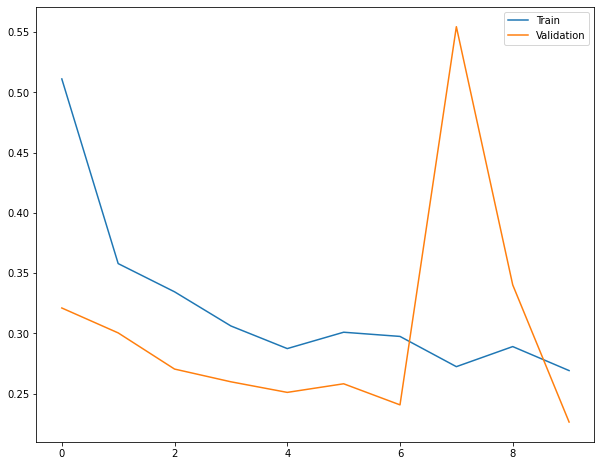

In [62]:

import matplotlib.pyplot as plt

def plot_test_val(train_losses, valid_loss):
    '''   
    Plot the training and validation loss for each epoch
    Input:
        train_losses: list of training losses for each epoch
        valid_loss: list of validation losses for each epoch
    '''
    plt.figure(figsize=(10, 8))
    plt.plot(train_losses, label='Train')
    plt.plot(valid_loss, label='Validation')
    plt.legend()
    plt.show()


plot_test_val(train_losses, valid_losses)

In [63]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [1]:
# model's performance
preds = np.argmax(preds, axis = 1)
print("BERT w/ Preprocessing and Lemmatization")
print(classification_report(test_y, preds))

NameError: ignored

**Some notes**:
- The preprocessig steps does not improve the results after the removal of stopwords and punctuation.
- BERT and it's family of models learns to compute text representations in context. In the sense, that the representations computed for a word in a specific sentence would be different from the representations for the same word in a different sentence.
- This context also comprises stopwords and punctuation which can very much change the meaning of a sentence. 
- *For example*, a question mark can certainly change the overall meaning of a sentence. Therefore, removing stopwords and punctuation would just imply removing context which BERT could have used to get better results.






